# Load Paradise Municipal Boundaries and Census Tracts

This notebook contains processing steps for clipping California wide datasets to extracts for the city of Paradise. This is needed because the original datasets are too large to be stored in GitHub.

For basic setup: First, select the `Python 3-0.9.4` kernel within CyberGISX. Then, make sure the primary software packages are using the expected versions.

## Load Geopandas

Geopandas is a library used for geospatial processing.

In [58]:
# Note - the Python 3-0.9.4 kernel is needed for the code to work

import geopandas as gpd
import pandas as pd
print("Geopandas version is ", gpd.__version__) # expected version is 0.13.2

Geopandas version is  0.13.2


## Extract Paradise Boundary from California Cities

City boundaries for California cities can be downloaded from the California State Geoportal. This dataset is `California City Boundaries and Identifiers with Coastal Buffers`, authored by the `California Department of Technology`, and can be downloaded from the following link: https://gis.data.ca.gov/datasets/be8a1cd8eff242b0a25feb54e5a2f5a6_2/explore . 

The original California City Boundaries file is too large to host on GitHub. The following code was used to extract boundaries for Paradise from the file donloaded at the above California State Geoportal. The extracted file is saved as `Paradise_bounds.geojson`. 

To reproduce, first download the full California City Boundaries dataset from the link above and replace `California_Cities.geojson` in the following code with your name for this downloaded file.

In [6]:
# this section is commented out because the file `California_Cities.geojson` is large
# download the file from the California State Geoportal
# and uncomment this section to reproduce locally

# replace 'California_Cities.geojson' with the name for your downloaded file
california_cities = gpd.read_file('California_Cities.geojson')
paradise_bd = california_cities[california_cities.CITY == "Paradise"]
paradise_bd.to_file("Paradise_bounds.geojson", driver='GeoJSON')

## Extract Census Tracts from California

2018 TIGER/Line Shapefiles for Census Tracts can be downloaded for California from https://www.census.gov/cgi-bin/geo/shapefiles/index.php.

To reproduce, first download the full California 2018 TIGER/Line Shapefiles dataset from the link above and replace `census_tract_export/tl_2018_06_tract.shp` in the following code with your path to the downloaded file.

In [52]:
# Load California Census Tracts
ca_ct = gpd.read_file('census_tract_export/tl_2018_06_tract.shp')

In [53]:
# Extract Butte County Census Tracts
# Butte County FIPS code is 007
butte = ca_ct[ca_ct["COUNTYFP"] == "007"]
butte = butte.to_crs("EPSG:4269")

<Axes: >

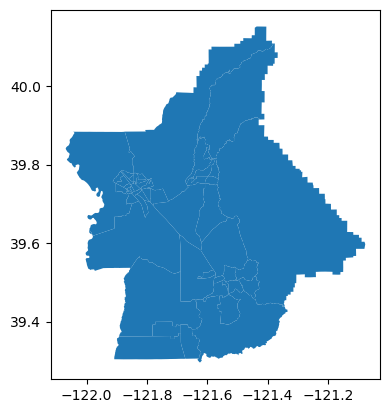

In [54]:
# Plot result
butte.plot()

In [55]:
# Save as shapefile
butte.to_file("census_tract_export/butte_tracts.shp")

## Join Households Data to Census Tract Geometries

Household data is used to initially place vehicles in proportion to households within census tracts.

In this section, we will clean the households census data file for Paradise and join it to the census tract shapefile. This section assumes you have already downloaded households data from [US Census Data Table S1101 2014-2018](https://data.census.gov/cedsci/table?q=S1101&tid=ACSST1Y2018.S1101) American Community Survey 5-Year Estimates, Table S1101.

First load the raw data and select only needed columns.

In [85]:
# load the raw data
butte_hh_raw = pd.read_csv("households/ACSST5Y2018.S1101_2024-11-04T130653/ACSST5Y2018.S1101-Data.csv")
# select only important columns
butte_hh_raw = butte_hh_raw[['GEO_ID', 'NAME', 'S1101_C01_001E']]
# rename columns for easier use
butte_hh_raw = butte_hh_raw.rename(columns={'GEO_ID': 'CT_GEO_ID', 'NAME': 'CT_NAME', 'S1101_C01_001E': 'Tot_Est_HH'})

In [86]:
# preview the initial contents
butte_hh_raw.head()

,CT_GEO_ID,CT_NAME,Tot_Est_HH
0,Geography,Geographic Area Name,Estimate!!Total!!HOUSEHOLDS!!Total households
1,0400000US06,California,12965435
2,0500000US06007,"Butte County, California",86797
3,0600000US0600792380,"Paradise CCD, Butte County, California",19347
4,1400000US06007000102,"Census Tract 1.02, Butte County, California",1588


The census tract data has overview rows for California, Butte County, and Paradise. Remove those extra rows.

In [89]:
# select only census tracts and preview
butte_hh = butte_hh_raw.iloc[4:]
# shorten the GEO id by removing the initial section ('1400000US')
butte_hh["GEOID"] = butte_hh["CT_GEO_ID"].str[9:]
butte_hh.head()

/tmp/ipykernel_397/211468268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  butte_hh["GEOID"] = butte_hh["CT_GEO_ID"].str[9:]


,CT_GEO_ID,CT_NAME,Tot_Est_HH,GEOID
4,1400000US06007000102,"Census Tract 1.02, Butte County, California",1588,06007000102
5,1400000US06007000103,"Census Tract 1.03, Butte County, California",1640,06007000103
6,1400000US06007000104,"Census Tract 1.04, Butte County, California",2286,06007000104
7,1400000US06007000201,"Census Tract 2.01, Butte County, California",1832,06007000201
8,1400000US06007000202,"Census Tract 2.02, Butte County, California",1714,06007000202


Load the shapefile of census tracts exported above in ths notebook.

In [93]:
# load Butte County Census tracts shapefile and preview
butte_geo = gpd.read_file("census_tract_export/butte_tracts.shp")
butte_geo.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,007,001703,06007001703,17.03,Census Tract 17.03,G5020,S,3830135,1351,+39.8262662,-121.6019972,"POLYGON ((-121.61216 39.82247, -121.61165 39.8..."
1,06,007,001704,06007001704,17.04,Census Tract 17.04,G5020,S,325483025,3681154,+39.9601080,-121.5013525,"POLYGON ((-121.63424 39.86513, -121.63410 39.8..."
2,06,007,002601,06007002601,26.01,Census Tract 26.01,G5020,S,20082985,38288,+39.4867836,-121.4581641,"POLYGON ((-121.49693 39.50588, -121.49562 39.5..."
3,06,007,002602,06007002602,26.02,Census Tract 26.02,G5020,S,18244927,7521121,+39.5272273,-121.4667585,"POLYGON ((-121.50935 39.53883, -121.50844 39.5..."
4,06,007,003002,06007003002,30.02,Census Tract 30.02,G5020,S,16689822,294750,+39.4826967,-121.5599592,"POLYGON ((-121.61449 39.45633, -121.61442 39.4..."


Finally, use geopandas to merge the households to the census tracts and export the merged shapefile.

In [94]:
# Merge household counts to census tracts based on GEOID
butte_geo = butte_geo.merge(butte_hh, on='GEOID')
# preview
butte_geo.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,CT_GEO_ID,CT_NAME,Tot_Est_HH
0,06,007,001703,06007001703,17.03,Census Tract 17.03,G5020,S,3830135,1351,+39.8262662,-121.6019972,"POLYGON ((-121.61216 39.82247, -121.61165 39.8...",1400000US06007001703,"Census Tract 17.03, Butte County, California",1212
1,06,007,001704,06007001704,17.04,Census Tract 17.04,G5020,S,325483025,3681154,+39.9601080,-121.5013525,"POLYGON ((-121.63424 39.86513, -121.63410 39.8...",1400000US06007001704,"Census Tract 17.04, Butte County, California",1306
2,06,007,002601,06007002601,26.01,Census Tract 26.01,G5020,S,20082985,38288,+39.4867836,-121.4581641,"POLYGON ((-121.49693 39.50588, -121.49562 39.5...",1400000US06007002601,"Census Tract 26.01, Butte County, California",968
3,06,007,002602,06007002602,26.02,Census Tract 26.02,G5020,S,18244927,7521121,+39.5272273,-121.4667585,"POLYGON ((-121.50935 39.53883, -121.50844 39.5...",1400000US06007002602,"Census Tract 26.02, Butte County, California",1651
4,06,007,003002,06007003002,30.02,Census Tract 30.02,G5020,S,16689822,294750,+39.4826967,-121.5599592,"POLYGON ((-121.61449 39.45633, -121.61442 39.4...",1400000US06007003002,"Census Tract 30.02, Butte County, California",1073


In [98]:
# export
butte_geo.to_file("census_tract_export_init/Butte_tracts_HH.shp")